In [4]:
import os
import cv2
import numpy as np
import onnxruntime as ort

from preprocessing import (
    subsample_point_cloud, 
    create_digital_elevation_model,
    pad_multiplo,
    create_input)

from postprocessing import(
    get_binary_img,
    get_componets,
    get_segments,
    fast_thinning,
    calculate_angle,
    find_distance
)

class PretilNet:
    def __init__(self, weights="model.onnx", providers=('CUDAExecutionProvider',)):
        super().__init__()  # Initialize the parent class
        self.session = ort.InferenceSession(weights, providers=providers)
        self.inputs = self.session.get_inputs()
        self.outputs = self.session.get_outputs()

    def __repr__(self):
        session = self.session
        meta = session.get_modelmeta()
        info = f"{session._model_path} {meta.graph_name} {meta.producer_name}\n"
        info += "Inputs:\n"
        for input_node in session.get_inputs():
            info += f"{input_node.name} {input_node.shape} {input_node.type}\n"
        info += "Outputs:\n"
        for output_node in session.get_outputs():
            info += f"{output_node.name} {output_node.shape} {output_node.type}\n"
        return info

    def __call__(self, las_file, factor_size=0.1):

        ## Preprocessing
        dem_info = self.__preprocessing(las_file, factor_size)
        input = create_input(dem_info['dem']).astype(np.float32)
        
        ## IA
        inputs_dic = {self.inputs[0].name: input}  # If not a dictionary, create one.
        outputs = self.session.run(None, inputs_dic)  # Returns a list of tensors.
        
        ## Posprocessing
        return self.__postprocessing(outputs, dem_info['mask'])

    
    def __preprocessing(self, input_file, factor_size):
        las = subsample_point_cloud(input_file, factor=factor_size)
        dem_info = create_digital_elevation_model(las.x,las.y,las.z) # cambiar ahora es un dict dem_info
        dem_info['dem'], dem_info['mask'] = pad_multiplo(dem_info['dem'], dem_info['mask'])
        return dem_info

    def __postprocessing(self, outputs, mask):
        results = []

        mask = np.expand_dims(mask, -1)
        outputs = [o[0,:,:,:].transpose(1, 2, 0) * mask for o in outputs]
        
        img_class = outputs[0]
        img_pretil = outputs[1]

        binary_img = get_binary_img(img_class)
        valid_components, labels = get_componets(binary_img)
        
        binary_mask = binary_img.astype(bool)
        
        segments = get_segments(valid_components, labels)
        
        ANGLE_THRESHOLD = 30  # Umbral en grados para considerar cambio drástico
        MIN_SEGMENT_LENGTH = 20  # Longitud mínima de un segmento
        WINDOW_SIZE = 10  # Tamaño de la ventana para análisis
        STEP_SIZE = 5 
        
        # Procesar cada segmento por separado
        for segment_idx, segment in enumerate(segments):
            num_points = segment.shape[0]
            
            # Procesar puntos en el segmento con ventanas deslizantes
            for i in range(0, num_points - WINDOW_SIZE + 1, STEP_SIZE):
                window = segment[i:i+WINDOW_SIZE]
                x_win = window[:, 0]
                y_win = window[:, 1]
                
                # Regresión lineal para dirección
                try:
                    coeffs = np.polyfit(x_win, y_win, 1)
                    m = coeffs[0]
                    dx, dy = 1, m
                    length = np.hypot(dx, dy)
                    dir_x, dir_y = dx/length, dy/length
                except:
                    # Fallback a puntos extremos
                    dx = x_win[-1] - x_win[0]
                    dy = y_win[-1] - y_win[0]
                    length = np.hypot(dx, dy)
                    if length == 0:
                        continue
                    dir_x, dir_y = dx/length, dy/length
                
                # Direcciones perpendiculares
                perp_up = (-dir_y, dir_x)
                perp_down = (dir_y, -dir_x)
                
                # Punto medio de la ventana
                mid_idx = i + WINDOW_SIZE // 2
                x0, y0 = segment[mid_idx]
                
                # Calcular distancias
                d_up = find_distance(x0, y0, perp_up, binary_mask)
                d_down = find_distance(x0, y0, perp_down, binary_mask)
                width = (d_up + d_down) * 0.25
                
                # Dibujar línea de medición
                start_x = int(x0 - perp_up[0] * d_down)
                start_y = int(y0 - perp_up[1] * d_down)
                end_x = int(x0 + perp_up[0] * d_up)
                end_y = int(y0 + perp_up[1] * d_up)
                
                #cv2.line(visualization_img, (start_x, start_y), (end_x, end_y), (0,0,255), 1)
                #cv2.circle(visualization_img, (x0, y0), 2, (0,255,0), -1)
                
                # Obtener altura del pretil
                height = img_pretil[y0, x0]
                results.append((x0, y0, segment_idx, width, height))

        return results




In [6]:
import numpy as np

# Initialize the PretilNet model
model = PretilNet(weights="unet_dynamic.onnx")

path_las = '../data/reduced_Inspecciones_Aéreas_Cámara_L2_Lidar_1.las'

outputs = model(path_las)
print(outputs)

2025-03-31 16:58:36.001780959 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_147'. It is not used by any node and should be removed from the model.
2025-03-31 16:58:36.001795292 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_144'. It is not used by any node and should be removed from the model.
2025-03-31 16:58:36.001798243 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_138'. It is not used by any node and should be removed from the model.
2025-03-31 16:58:36.001800457 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_135'. It is not used by any node and should be removed from the model.
2025-03-31 16:58:36.001802610 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'val_121'. It is not used by any node and should be removed from the model.
2025-03-31 16:58:36.001804594 

[(np.int64(1028), np.int64(942), 0, 5.75, array([-0.52759621])), (np.int64(1023), np.int64(947), 0, 30.0, array([-2.14729966])), (np.int64(1018), np.int64(952), 0, 5.75, array([-0.46878154])), (np.int64(1013), np.int64(957), 0, 30.0, array([-1.95475138])), (np.int64(1008), np.int64(962), 0, 5.75, array([-0.4318709])), (np.int64(1005), np.int64(965), 0, 30.0, array([-1.80241002])), (np.int64(1010), np.int64(960), 0, 5.75, array([-0.46152876])), (np.int64(1015), np.int64(955), 0, 30.0, array([-2.00929973])), (np.int64(1020), np.int64(950), 0, 5.75, array([-0.47537782])), (np.int64(1025), np.int64(945), 0, 23.5, array([-2.196849])), (np.int64(1046), np.int64(925), 1, 4.5, array([0.23312846])), (np.int64(1041), np.int64(930), 1, 4.25, array([-1.03642938])), (np.int64(1036), np.int64(935), 1, 4.5, array([0.21168928])), (np.int64(1039), np.int64(932), 1, 4.0, array([-1.0793732])), (np.int64(1044), np.int64(927), 1, 4.5, array([0.21895176]))]


(1984, 1472, 3) (1984, 1472, 1)


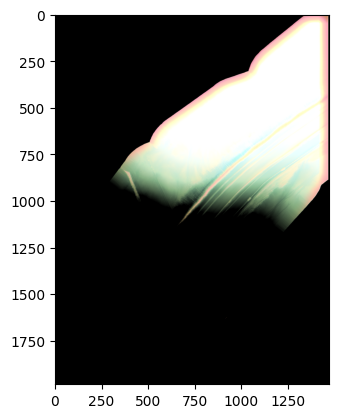

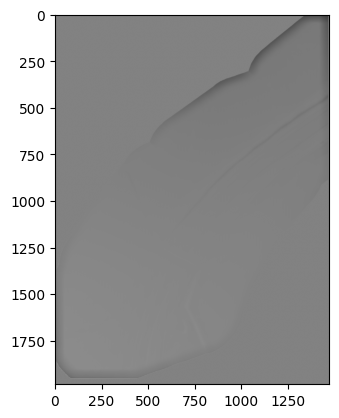

In [3]:
import matplotlib.pyplot as plt

mask = dem_info['mask']
mask = np.expand_dims(mask, -1)
outputs = [o[0,:,:,:].transpose(1, 2, 0) * mask for o in outputs]
        
o1 = outputs[0] 
o1 = (np.clip(o1,0,1)*255).astype(np.uint8)
o2 = outputs[1]
print(o1.shape, o2.shape)

plt.imshow(o1) 
plt.show()
plt.imshow(o2, cmap='gray') 
plt.show()